#  Tree-based Methods

- Here we describe tree-based methods for regression and
classification.
- These involve stratifying or segmenting the predictor space
into a number of simple regions.
- Since the set of splitting rules used to segment the
predictor space can be summarized in a tree, these types of
approaches are known as decision-tree methods.
- Tree-based methods are simple and useful for
interpretation.
- However they typically are not competitive with the best
supervised learning approaches in terms of prediction
accuracy.
- Hence we also discuss bagging, random forests, and
boosting. These methods grow multiple trees which are
then combined to yield a single consensus prediction.
- Combining a large number of trees can often result in
dramatic improvements in prediction accuracy, at the
expense of some loss interpretation.

### The Basics of Decision Trees
- Decision trees can be applied to both regression and
classification problems.
- We first consider regression problems, and then move on to
classification.

### Baseball Salary Data

In [18]:
import pandas as pd
import pandas.util.testing as tm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score

from itertools import groupby

import warnings

%matplotlib inline
plt.style.use('seaborn-white')

In [19]:
# find the location of graphviz so dot.exe is in the PATH
import os
common_path = r'C:\\Program Files\\Anaconda3'
dot_path = os.path.join(common_path, 'Library', 'bin', 'graphviz')
os.environ["PATH"] += os.pathsep + dot_path


In [20]:
def plot_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [21]:
# # This function creates images of tree models using pydot
# def plot_tree(estimator, features, class_names=None, filled=True):
#     tree = estimator
#     names = features
#     color = filled
#     classn = class_names
    
#     dot_data = StringIO()
#     export_graphviz(estimator, out_file=dot_data, 
#                     feature_names=features, class_names=classn, 
#                     filled=filled,
#                     precision=2)
#     graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
#     return Image(graph.create_png())

In [22]:
df_hitters = pd.read_csv('https://gist.githubusercontent.com/keeganhines/59974f1ebef97bbaa44fb19143f90bad/raw/d9bcf657f97201394a59fffd801c44347eb7e28d/Hitters.csv', index_col=0).dropna()
df_hitters.index.name = 'Player'
df_hitters.index = df_hitters.index.map(lambda x: x.replace('-', '', 1))
df_hitters["League"] = df_hitters["League"].astype('category')
df_hitters["Division"] = df_hitters["Division"].astype('category')
df_hitters["NewLeague"] = df_hitters["NewLeague"].astype('category')
df_hitters.head(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N


In [23]:
X = df_hitters[['Years', 'Hits']]
y = np.log(df_hitters.Salary)

In [24]:
# we can also use the option max_leaf_nodes=3 alone
regressionTree = DecisionTreeRegressor(max_depth=2, min_impurity_decrease=0.05)
regressionTree = regressionTree.fit(X, y)

In [25]:
regressionTree

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.05, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [26]:
graph, = plot_tree(regressionTree, ['Years', 'Hits'])

In [27]:
from graphviz import Source
s = Source(graph, filename="test.gv", format="png")

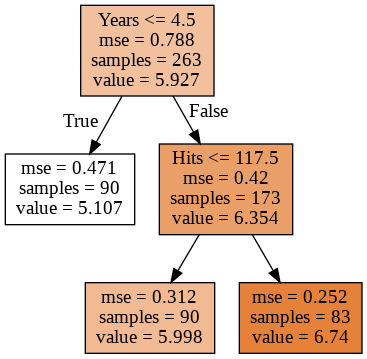

In [28]:
Image(s.view())

In [29]:
lines = []
for node, feature in enumerate(regressionTree.tree_.feature):
    if feature != -2: # node
        lines.append((feature, regressionTree.tree_.threshold[node]))

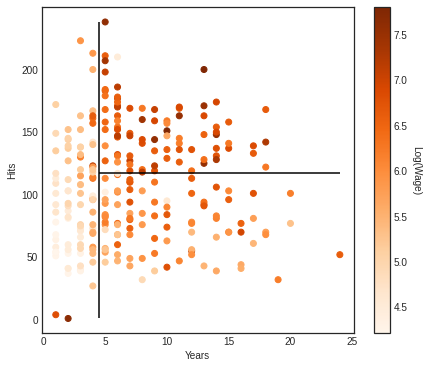

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
# the color indicates the value
sc = ax.scatter(X.Years, X.Hits, c=y, cmap='Oranges')
ax.set_ylabel('Hits')
ax.set_xlabel('Years')
# this algorithm doesn't really work for other cases...
last_threshold = None
for feature, threshold in lines:
    if feature == 0:
        if not last_threshold:
            ax.vlines(threshold, ymin=X.iloc[:,0].min(), ymax=X.iloc[:,1].max())
        else:
            ax.vlines(threshold, ymin=X.iloc[:,0].min(), ymax=last_threshold)
    else:
        if not last_threshold:
            ax.hlines(threshold, xmin=X.iloc[:,1].min(), xmax=X.iloc[:,0].max())
        else:
            ax.hlines(threshold, xmin=last_threshold, xmax=X.iloc[:,0].max())
    last_threshold = threshold
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Log(Wage)', rotation=-90, va="bottom");

- For the Hitters data, a regression tree for predicting the log
salary of a baseball player, based on the number of years that he
has played in the major leagues and the number of hits that he
made in the previous year.
- At a given internal node, the label (of the form Xj < tk)
indicates the left-hand branch emanating from that split, and
the right-hand branch corresponds to Xj * tk. For instance, the
split at the top of the tree results in two large branches. The
left-hand branch corresponds to Years<4.5, and the right-hand
branch corresponds to Years>=4.5.
- The tree has two internal nodes and three terminal nodes, or
leaves. The number in each leaf is the mean of the response for
the observations that fall there.

### Interpretation of results
- Years is the most important factor in determining Salary,
and players with less experience earn lower salaries than
more experienced players.
- Given that a player is less experienced, the number of Hits
that he made in the previous year seems to play little role
in his Salary.
- But among players who have been in the major leagues for
five or more years, the number of Hits made in the
previous year does affect Salary, and players who made
more Hits last year tend to have higher salaries.
- Surely an over-simplification, but compared to a regression
model, it is easy to display, interpret and explain

### Pruning a tree
- A better strategy is to grow a very large tree $T_{0},$ and then prune it back in order to obtain a subtree
- Cost complexity pruning - also known as weakest link pruning - is used to do this
- We consider a sequence of trees indexed by a nonnegative tuning parameter $\alpha$. For each value of $\alpha$ there corresponds
a subtree $T \subset T_{0}$ such that
$$
\sum_{m=1}^{|T|} \sum_{i: x_{i} \in R_{m}}\left(y_{i}-\hat{y}_{R_{m}}\right)^{2}+\alpha|T|
$$
is as small as possible. Here $|T|$ indicates the number of terminal nodes of the tree $T, R_{m}$ is the rectangle (i.e. the subset of predictor space) corresponding to the $m$ th terminal node, and $\hat{y}_{R_{m}}$ is the mean of the training observations in $R_{m}$

### Tree algorithm
1. Use recursive binary splitting to grow a large tree on the training data, stopping only when each terminal node has fewer than some minimum number of observations.
2. Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtrees, as a function of $\alpha$.
3. Use K-fold cross-validation to choose $\alpha$. For each $k=1, \ldots, K:$
    3.1 Repeat Steps 1 and 2 on the $\frac{K-1}{K}$ th fraction of the training data, excluding the $k$ th fold.
    3.2 Evaluate the mean squared prediction error on the data in the left-out $k$ th fold, as a function of $\alpha$. Average the results, and pick $\alpha$ to minimize the average error.
4. Return the subtree from Step 2 that corresponds to the chosen value of $\alpha$

In [31]:
# try to emulate tree prunning using the maximum number of leaf nodes
feature_names = ['Years', 'RBI', 'Hits', 'PutOuts', 'Walks', 'Runs']
X = df_hitters[feature_names]
y = np.log(df_hitters.Salary)



In [32]:
max_leafs_arr = range(2, 50)
scores = []
for max_leafs in max_leafs_arr:
    regressionTree = DecisionTreeRegressor(max_leaf_nodes=max_leafs)
    sc = cross_val_score(regressionTree, X, y, cv=10, scoring="neg_mean_squared_error")
    scores.append((-sc.mean(), sc.std()))
scores = np.array(scores)
best_min_leafs = max_leafs_arr[np.argmin(scores[:,0])]

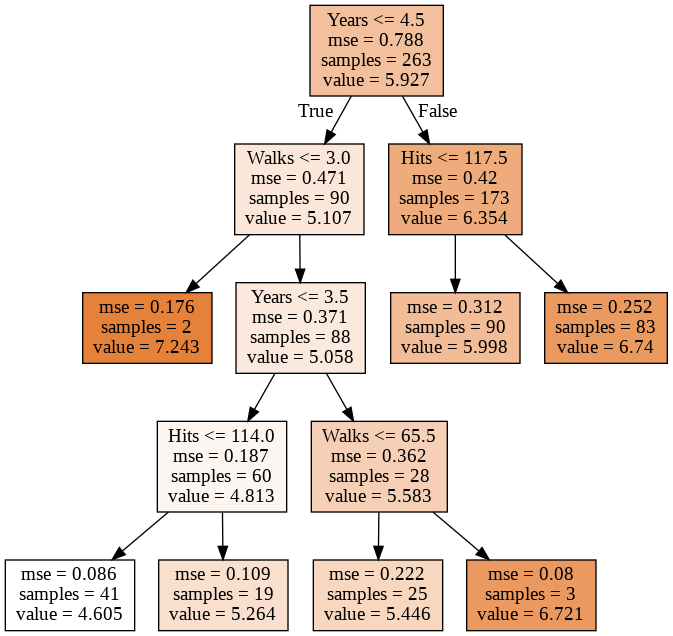

In [33]:
graph, = plot_tree(DecisionTreeRegressor(max_leaf_nodes=best_min_leafs).fit(X,y), feature_names)
s = Source(graph, filename="test.gv", format="png")
Image(s.view())

The result is different than the book.

### Classiffication Trees
- Very similar to a regression tree, except that it is used to
predict a qualitative response rather than a quantitative
one.
- For a classiffication tree, we predict that each observation
belongs to the most commonly occurring class of training
observations in the region to which it belongs.

### Gini index and Deviance
- The Gini index is defined by $\left.G=\sum_{e=1}^{K} \hat{p}_{m}\left(1-\hat{p}_{m}\right)\right)$
a measure of total variance across the $K$ classes. The Gini index takes on a small value if all of the $\hat{p}_{m k}$ 's are close to zero or one.
For this reason the Gini index is referred to as a measure of node purity - a small value indicates that a node contains predominantly observations from a single class.
- An alternative to the Gini index is cross-entropy, given by
$$
D=-\sum_{k=1}^{K} \hat{p}_{m k} \log \hat{p}_{m k}
$$
- It turns out that the Gini index and the cross-entropy are very similar numerically.

### Example: heart data
- These data contain a binary outcome HD for 303 patients
who presented with chest pain.
- An outcome value of Yes indicates the presence of heart
disease based on an angiographic test, while No means no
heart disease.
- There are 13 predictors including Age, Sex, Chol (a
cholesterol measurement), and other heart and lung
function measurements.
- Cross-validation yields a tree with six terminal nodes. See
next figure.

In [34]:
df_heart = pd.read_csv('https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Heart.csv', index_col=0).dropna()
for cat_col in ['ChestPain', 'Thal', 'AHD']:
    df_heart[cat_col] = df_heart[cat_col].astype('category')
    print(f'{cat_col}: {df_heart[cat_col].cat.categories.values}')

ChestPain: ['asymptomatic' 'nonanginal' 'nontypical' 'typical']
Thal: ['fixed' 'normal' 'reversable']
AHD: ['No' 'Yes']


In [35]:
df_heart.head(3)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes


In [36]:
X = pd.get_dummies(df_heart[df_heart.columns.difference(['AHD'])], drop_first=True)
y = pd.get_dummies(df_heart.AHD, drop_first=True)
clf = DecisionTreeClassifier(max_depth=6, min_impurity_decrease=0.01)
clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.01, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

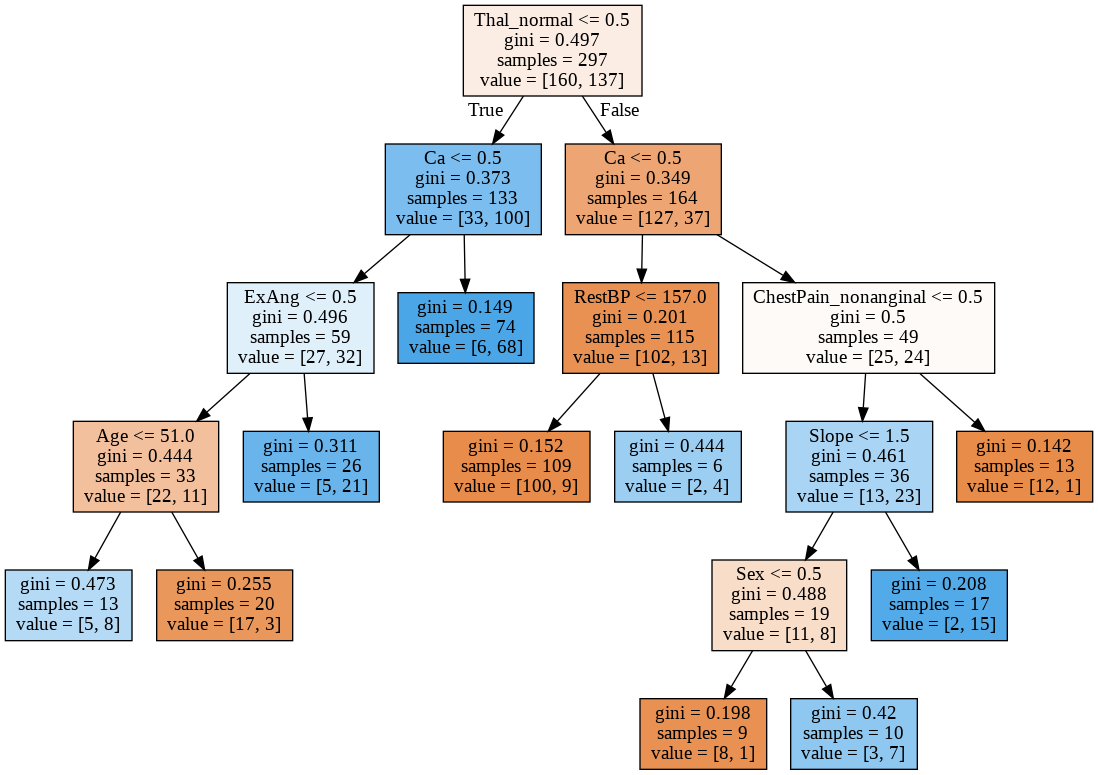

In [37]:
# unpruned tree
graph, = plot_tree(clf, X.columns)
s = Source(graph, filename="test.gv", format="png")
Image(s.view())

In [38]:
scores = []
max_leafs_arr = range(2, 50)
for max_leafs in max_leafs_arr:
    regressionTree = DecisionTreeClassifier(max_leaf_nodes=max_leafs)
    sc = cross_val_score(regressionTree, X, y, cv=10)
    scores.append((sc.mean(), sc.std()))
scores = np.array(scores)
best_min_leafs = max_leafs_arr[np.argmin(scores[:,0])]

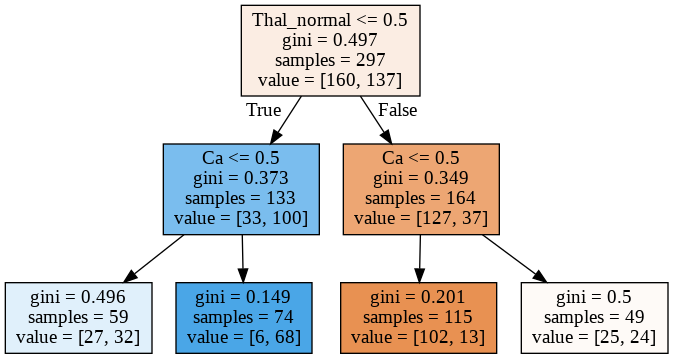

In [39]:
graph, = plot_tree(DecisionTreeClassifier(max_leaf_nodes=best_min_leafs).fit(X,y), X.columns)
s = Source(graph, filename="test.gv", format="png")
Image(s.view())

### Pros and cons of Trees
- Trees are very easy to explain to people. In fact, they are
even easier to explain than linear regression!
- Some people believe that decision trees more closely mirror
human decision-making than do the regression and
classiffication approaches seen in previous chapters.
- Trees can be displayed graphically, and are easily
interpreted even by a non-expert (especially if they are
small).
- Trees can easily handle qualitative predictors without the
need to create dummy variables.
- Unfortunately, trees generally do not have the same level of
predictive accuracy as some of the other regression and
classiffication approaches seen in this book.
However, by aggregating many decision trees, the predictive
performance of trees can be substantially improved. We
introduce these concepts next.

### Bagging
- We generate $B$ different bootstrapped training data sets. We then train our method on the $b$ th bootstrapped training set in order to get $\hat{f}^{* b}(x),$ the prediction at a point $x .$ We then average all the predictions to obtain
$$
\hat{f}_{\mathrm{bag}}(x)=\frac{1}{B} \sum_{b=1}^{B} \hat{f}^{* b}(x)
$$
This is called bagging.

In [40]:
X = pd.get_dummies(df_heart[df_heart.columns.difference(['AHD'])], drop_first=True)
y = pd.get_dummies(df_heart.AHD, drop_first=True).values.ravel()
scores_OOB_bagging = []
scores_bagging = []
trees_number = range(1, 100, 5)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for B in trees_number:
        clf_bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=B, oob_score=True)
        clf_bag.fit(X, y)
        scores_OOB_bagging.append(1-clf_bag.oob_score_)
        # this is computationally expensive, so better use OOB
        sc = 1-cross_val_score(clf_bag, X, y, cv=2)
        scores_bagging.append(sc.mean())
scores_OOB_bagging = np.array(scores_OOB_bagging)
scores_bagging = np.array(scores_bagging)

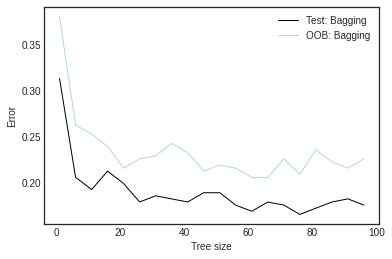

In [41]:
plt.plot(trees_number, scores_bagging, 'black', label='Test: Bagging', lw=1)
plt.plot(trees_number, scores_OOB_bagging, 'lightblue', label='OOB: Bagging', lw=1)
plt.legend()
plt.xlabel('Tree size')
plt.ylabel('Error');

###  Random Forest
- We applied random forests to a high-dimensional biological
data set consisting of expression measurements of 4,718
genes measured on tissue samples from 349 patients.
- There are around 20,000 genes in humans, and individual
genes have different levels of activity, or expression, in
particular cells, tissues, and biological conditions.
- Each of the patient samples has a qualitative label with 15
different levels: either normal or one of 14 different types of
cancer.
- We use random forests to predict cancer type based on the
500 genes that have the largest variance in the training set.
- We randomly divided the observations into a training and a
test set, and applied random forests to the training set for
three diffierent values of the number of splitting variables m.

In [42]:
scores_p_rnd_forest = []
scores_p2_rnd_forest = []
scores_sqrt_p_rnd_forest = []
trees_number = range(1, 200, 10)
p = len(X.columns)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for B in trees_number:
        clf_p = RandomForestClassifier(n_estimators=B, max_features=p,  oob_score=True, n_jobs=-1)
        clf_p.fit(X, y)
        scores_p_rnd_forest.append(1-clf_p.oob_score_)
        
        clf_p_2 = RandomForestClassifier(n_estimators=B, max_features=p//2, oob_score=True, n_jobs=-1)
        clf_p_2.fit(X, y)
        scores_p2_rnd_forest.append(1-clf_p_2.oob_score_)
        
        clf_sqrt_p = RandomForestClassifier(n_estimators=B, max_features=int(np.sqrt(p)), oob_score=True, n_jobs=-1)
        clf_sqrt_p.fit(X, y)
        scores_sqrt_p_rnd_forest.append(1-clf_sqrt_p.oob_score_)
scores_p_rnd_forest = np.array(scores_p_rnd_forest)
scores_p2_rnd_forest = np.array(scores_p2_rnd_forest)
scores_sqrt_p_rnd_forest = np.array(scores_sqrt_p_rnd_forest)

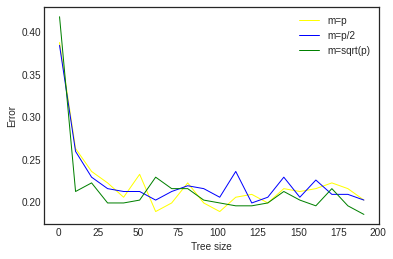

In [43]:
plt.plot(trees_number, scores_p_rnd_forest, 'yellow', label='m=p', lw=1)
plt.plot(trees_number, scores_p2_rnd_forest, 'blue', label='m=p/2', lw=1)
plt.plot(trees_number, scores_sqrt_p_rnd_forest, 'green', label='m=sqrt(p)', lw=1)
plt.legend()
plt.xlabel('Tree size')
plt.ylabel('Error');

### Boosting
- Like bagging, boosting is a general approach that can be
applied to many statistical learning methods for regression
or classiffication. We only discuss boosting for decision
trees.
- Recall that bagging involves creating multiple copies of the
original training data set using the bootstrap, fitting a
separate decision tree to each copy, and then combining all
of the trees in order to create a single predictive model.
- Notably, each tree is built on a bootstrap data set,
independent of the other trees.
- Boosting works in a similar way, except that the trees are
grown sequentially: each tree is grown using information
from previously grown trees.

Graphs not displayed due to system delays but it has similar codebase like Bagging.

### Variable importance measure
- For bagged/RF regression trees, we record the total
amount that the RSS is decreased due to splits over a given
predictor, averaged over all B trees. A large value indicates
an important predictor.
- Similarly, for bagged/RF classiffication trees, we add up the
total amount that the Gini index is decreased by splits over
a given predictor, averaged over all B trees.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


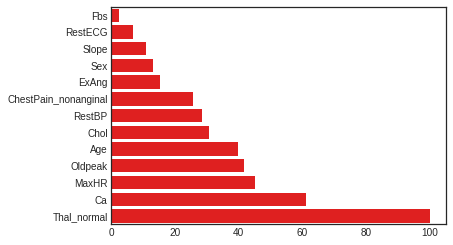

In [44]:
feature_importances = np.sum(est.feature_importances_ for est in clf_bag.estimators_)/clf_bag.n_estimators

# sum categorical features that belong together
original_cols = df_heart.columns.difference(['AHD'])
# get only categorical features from the original ones
cat_features = [col for col in original_cols if isinstance(df_heart[col].dtype, pd.api.types.CategoricalDtype)]
# get features that have been expanded from the categorical ones
rep_feat = [col for col in X.columns if any(col.startswith(cat) for cat in cat_features)]
# return the position of the categorical feature that s belongs to
def groupby_cat_feature(s):
    for cat_feature in cat_features:
        if cat_feature in s:
            return cat_features.index(cat_feature)
    return -1
# get the indices of the categorical features that belong together
groups_idx = [[X.columns.tolist().index(feat) for feat in group] for _, group in groupby(rep_feat, key=groupby_cat_feature)]
# index of first feature in each group
first_idx = [val for (val, *_) in groups_idx]
# indices of other
other_idx = [item for sublist in [val for (_, *val) in groups_idx] for item in sublist]
# add those values
feature_importances_clean = feature_importances.copy()
feature_importances_clean[first_idx] = [np.sum(feature_importances[group_i]) for group_i in groups_idx]
feature_importances_clean = np.delete(feature_importances_clean, other_idx)
cols_clean = np.delete(X.columns, other_idx)

sort_idx = np.argsort(feature_importances_clean)
sns.barplot(feature_importances_clean[sort_idx]/np.max(feature_importances_clean)*100, cols_clean[sort_idx], color='r');

### Summary
- Decision trees are simple and interpretable models for
regression and classiffication
- However they are often not competitive with other
methods in terms of prediction accuracy
- Bagging, random forests and boosting are good methods
for improving the prediction accuracy of trees. They work
by growing many trees on the training data and then
combining the predictions of the resulting ensemble of trees.
- The latter two methods| random forests and boosting|
are among the state-of-the-art methods for supervised
learning. However their results can be dicult to interpret.

### End of Chapter 8